In [3]:
library(data.table)
library(glmnet)
library(ggplot2)
library(lubridate, quietly=TRUE)
library(zoo, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(GGally, quietly=TRUE)
library(caTools)
library(rpart)
library(rattle)
library(caret)
library(e1071)
library(randomForest)
library(gbm)

### Performance Function

In [4]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

# Fourth Dataset

### Loading Dataset

In [5]:
blog_data=read.csv("blogData_train.csv")
setnames(blog_data,"X1.0.2", "target")

In [6]:
blog_data=as.data.table(blog_data)
blog_data=blog_data[0:10000]
blog_data=na.omit(blog_data)
str(blog_data)

Classes 'data.table' and 'data.frame':	10000 obs. of  281 variables:
 $ X40.30467   : num  40.3 40.3 40.3 40.3 40.3 ...
 $ X53.845657  : num  53.8 53.8 53.8 53.8 53.8 ...
 $ X0.0        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X401.0      : num  401 401 401 401 401 401 401 401 401 401 ...
 $ X15.0       : num  15 15 15 15 15 15 15 15 15 15 ...
 $ X15.52416   : num  15.5 15.5 15.5 15.5 15.5 ...
 $ X32.44188   : num  32.4 32.4 32.4 32.4 32.4 ...
 $ X0.0.1      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X377.0      : num  377 377 377 377 377 377 377 377 377 377 ...
 $ X3.0        : num  3 3 3 3 3 3 3 3 3 3 ...
 $ X14.044226  : num  14 14 14 14 14 ...
 $ X32.615417  : num  32.6 32.6 32.6 32.6 32.6 ...
 $ X0.0.2      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X377.0.1    : num  377 377 377 377 377 377 377 377 377 377 ...
 $ X2.0        : num  2 2 2 2 2 2 2 2 2 2 ...
 $ X34.567566  : num  34.6 34.6 34.6 34.6 34.6 ...
 $ X48.475178  : num  48.5 48.5 48.5 48.5 48.5 ...
 $ X0.0.3      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 

In [7]:
set.seed(35)
spl=sample.split(blog_data$target, SplitRatio = 0.8)
blog_train=subset(blog_data,spl==TRUE)
blog_test=subset(blog_data,spl==FALSE)

## Penalized Regression Approaches(PRA)

### L1 Penalty with Mean Square Error measure

In order to tune lambda values, glmnet packages are used to get best lambda values for Penalized Regression. 

In [9]:
train_mat_blog=data.matrix(blog_train[complete.cases(blog_train),-c("target"),with=F])

result_vec_blog=as.vector(t(blog_train[complete.cases(blog_train),"target"]))

cvfit_blog=cv.glmnet(train_mat_blog,result_vec_blog,family="gaussian",nfolds = 10,type.measure = "mse")

test_mat_blog=data.matrix(blog_test[complete.cases(blog_test),-c("target")])

lasso_model_blog_mse_min <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog$lambda.min, standardize = FALSE)
lasso_model_blog_mse_1se <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog$lambda.1se, standardize = FALSE)
lasso_model_blog_mse_10th <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog$lambda[10], standardize = FALSE)

In [25]:
# train_mat_blog=data.matrix(blog_train[complete.cases(blog_train),-c("target"),with=F])

# result_vec_blog=as.vector(t(blog_train[complete.cases(blog_train),"target"]))

# cvfit_blog=cv.glmnet(train_mat_blog,result_vec_blog,family="gaussian",nfolds = 10)

# test_mat_blog=data.matrix(blog_test[complete.cases(blog_test),-c("target")])

# lasso_model_blog <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog$lambda.1se, standardize = FALSE)

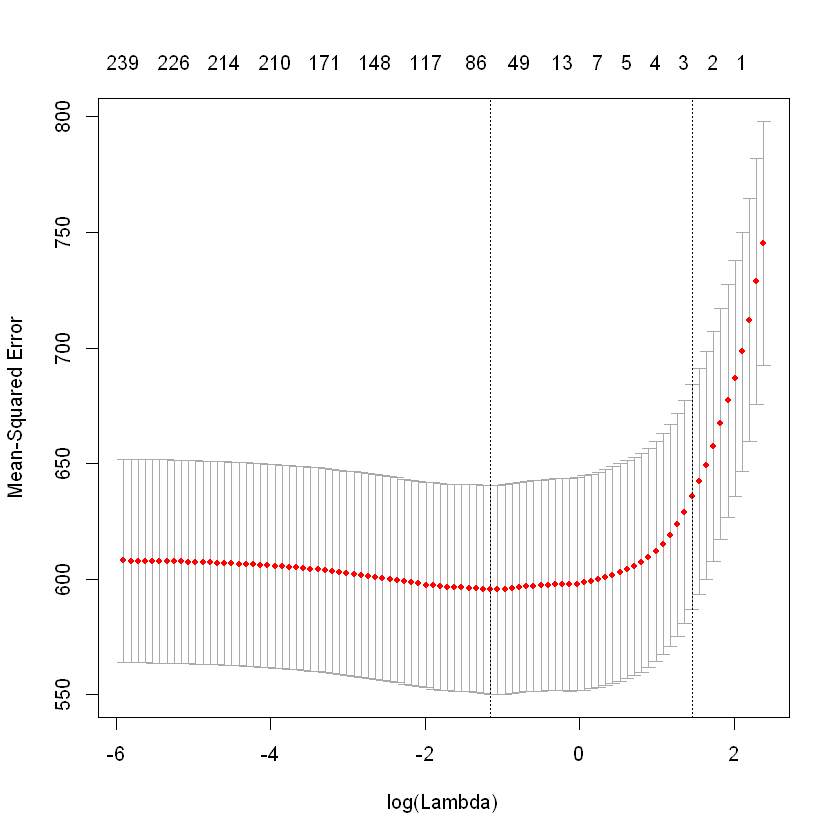

In [10]:
plot(cvfit_blog)

### Lambda Values for Mean Square Error Values

In [11]:
cvfit_blog$lambda.min

[1] 0.3152804

In [12]:
cvfit_blog$lambda.1se

[1] 4.265895

In [13]:
cvfit_blog$lambda[10]

[1] 4.681814

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [15]:
prediction_pra_mse_blog_min <- predict(lasso_model_blog_mse_min, s = cvfit_blog$lambda.min, newx = test_mat_blog)
prediction_pra_mse_blog_1se <- predict(lasso_model_blog_mse_1se, s = cvfit_blog$lambda.1se, newx = test_mat_blog)
prediction_pra_mse_blog_10th <- predict(lasso_model_blog_mse_10th, s = cvfit_blog$lambda[10], newx = test_mat_blog)

## L1 Penalty with Mean Absolute Error measure

In [16]:
train_mat_blog=data.matrix(blog_train[complete.cases(blog_train),-c("target"),with=F])

result_vec_blog=as.vector(t(blog_train[complete.cases(blog_train),"target"]))

cvfit_blog_mae=cv.glmnet(train_mat_blog,result_vec_blog,family="gaussian",nfolds = 10,type.measure = "mae")

test_mat_blog=data.matrix(blog_test[complete.cases(blog_test),-c("target")])

lasso_model_blog_mae_min <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog_mae$lambda.min, standardize = FALSE)
lasso_model_blog_mae_1se <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog_mae$lambda.1se, standardize = FALSE)
lasso_model_blog_mae_10th <- glmnet(train_mat_blog,result_vec_blog, alpha = 1, lambda = cvfit_blog_mae$lambda[10], standardize = FALSE)

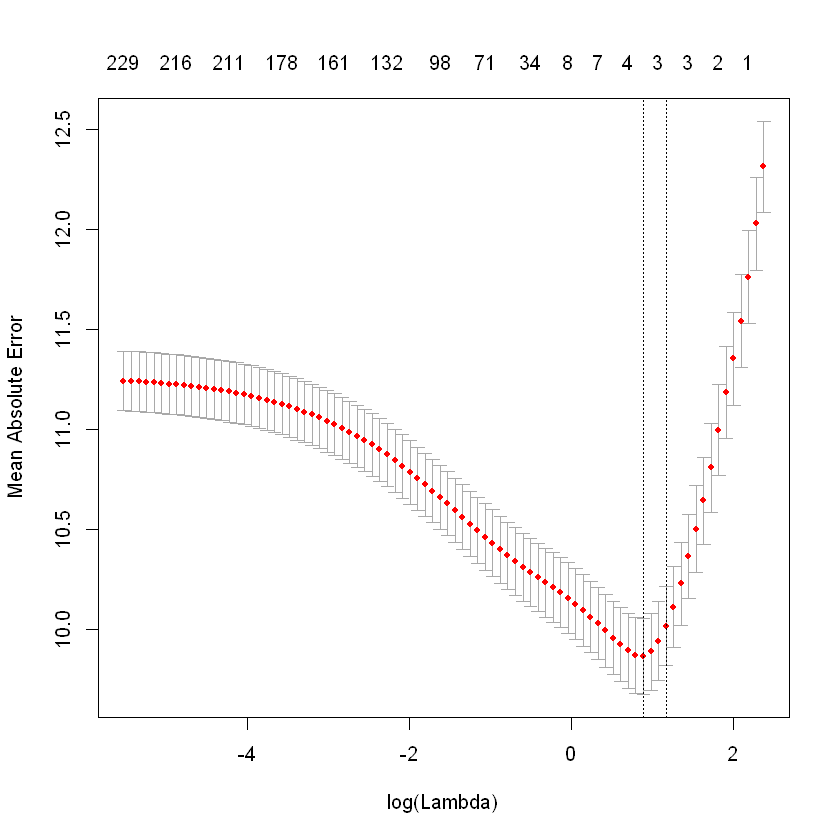

In [17]:
plot(cvfit_blog_mae)

### Lambda Values for Mean Square Error Values

In [18]:
cvfit_blog_mae$lambda.min

[1] 2.441102

In [19]:
cvfit_blog_mae$lambda.1se

[1] 3.226993

In [20]:
cvfit_blog_mae$lambda[10]

[1] 4.681814

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [21]:
prediction_pra_mae_blog_min <- predict(lasso_model_blog_mae_min, s = cvfit_blog_mae$lambda.min, newx = test_mat_blog)
prediction_pra_mae_blog_1se <- predict(lasso_model_blog_mae_1se, s = cvfit_blog_mae$lambda.1se, newx = test_mat_blog)
prediction_pra_mae_blog_10th <- predict(lasso_model_blog_mae_10th, s = cvfit_blog_mae$lambda[10], newx = test_mat_blog)

### Performance Measure for Lasso Regression

In [23]:
perf_dt("Blog Data Set for Lasso Function with min lambda and mse objective", as.numeric(blog_test$target), prediction_pra_mse_blog_min)
perf_dt("Blog Data Set for Lasso Function with 1se lambda and mse objective", as.numeric(blog_test$target), prediction_pra_mse_blog_1se)
perf_dt("Blog Data Set for Lasso Function with 10th lambda and mse objective", as.numeric(blog_test$target), prediction_pra_mse_blog_10th)

perf_dt("Blog Data Set for Lasso Function with min lambda and mae objective", as.numeric(blog_test$target), prediction_pra_mae_blog_min)
perf_dt("Blog Data Set for Lasso Function with 1se lambda and mae objective", as.numeric(blog_test$target), prediction_pra_mae_blog_1se)
perf_dt("Blog Data Set for Lasso Function with 10th lambda and mae objective", as.numeric(blog_test$target), prediction_pra_mae_blog_10th)

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with min lambda and mse objective,1977,7.152757,16.66787,-0.2243988,Inf,0.3313882,8.906574,1.245195


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with 1se lambda and mse objective,1977,7.152757,16.66787,-0.2275835,Inf,0.3304201,8.798435,1.230076


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with 10th lambda and mse objective,1977,7.152757,16.66787,-0.2276585,Inf,0.33034,8.790585,1.228979


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with min lambda and mae objective,1977,7.152757,16.66787,-0.2257989,Inf,0.3308737,8.852091,1.237578


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with 1se lambda and mae objective,1977,7.152757,16.66787,-0.2264184,Inf,0.3306597,8.827931,1.2342


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Blog Data Set for Lasso Function with 10th lambda and mae objective,1977,7.152757,16.66787,-0.2276585,Inf,0.33034,8.790585,1.228979


In [27]:
res_pra_blog=data.table(actual=blog_test$target,
                   prediction_val=prediction_pra_blog)
setnames(res_pra_blog, "prediction_val.1", "prediction")

In [28]:
perf_dt("First Data Set for Lasso Function", as.numeric(res_pra_blog$actual), res_pra_blog$prediction)

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Lasso Function,1977,7.152757,16.66787,-0.2301968,Inf,0.3298626,8.726155,1.219971


## Decision Tree(DT)

In [107]:
set.seed(35)

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7220, 7222, 7221, 7220, 7220, 7221, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  24.16891  0.3422344   7.344132
  0.01  23.89103  0.2693667   8.761947
  0.02  23.59127  0.2550694   9.271682
  0.03  24.03240  0.2313970   9.492628
  0.04  24.29328  0.2049342   9.704084
  0.05  24.76363  0.1733985  10.038565
  0.06  24.81820  0.1692477  10.090411
  0.07  25.32670  0.1311470  10.368420
  0.08  25.36472  0.1293879  10.422255
  0.09  25.36472  0.1293879  10.422255
  0.10  25.36472  0.1293879  10.422255

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.02.
CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7221, 7222, 7220, 7220, 7221, 7221, ... 
Resampling results across tuning parameters:

  c

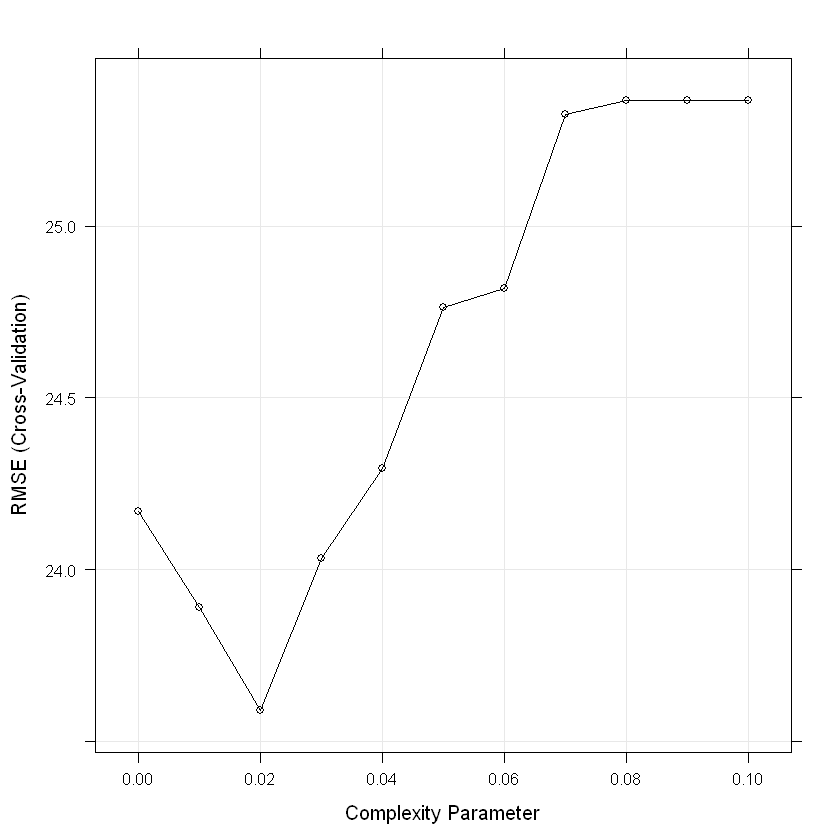

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7220, 7220, 7221, 7220, 7220, 7222, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  23.61666  0.3789243   7.471156
  0.01  23.11314  0.3054489   8.719794
  0.02  24.36965  0.2294315   9.417695
  0.03  23.68938  0.2470209   9.416471
  0.04  24.15659  0.2110688   9.683261
  0.05  24.48568  0.1869299   9.996503
  0.06  24.76275  0.1630282  10.179407
  0.07  25.13900  0.1359057  10.401527
  0.08  25.15625  0.1345778  10.426164
  0.09  25.15625  0.1345778  10.426164
  0.10  25.15625  0.1345778  10.426164

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


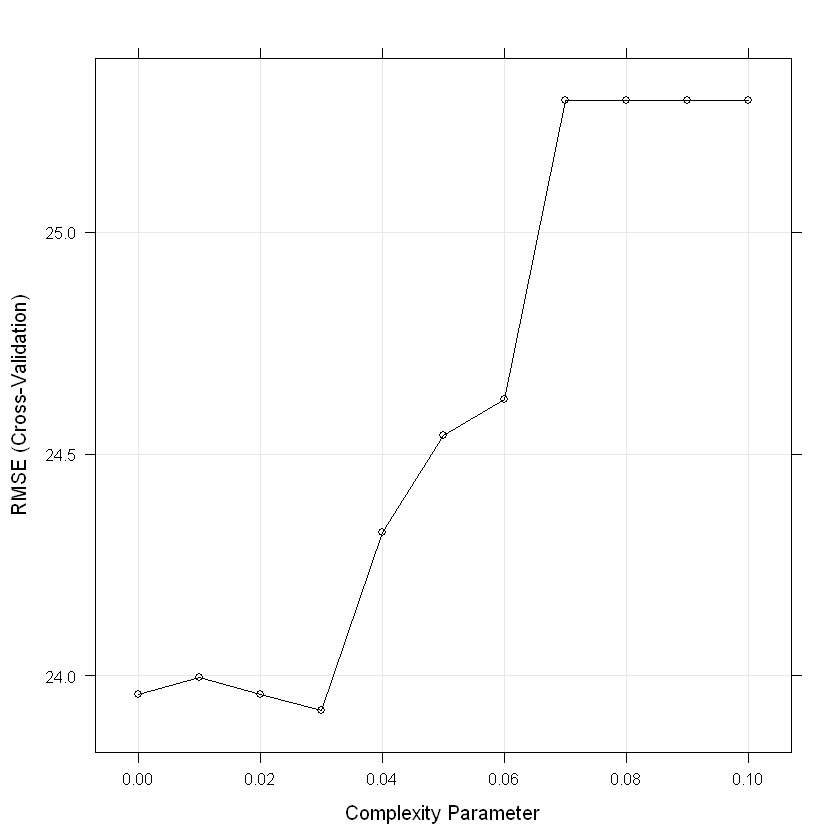

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7221, 7221, 7221, 7221, 7220, 7220, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.78362  0.3732043   7.401200
  0.01  22.59291  0.3192507   8.701588
  0.02  23.06662  0.2836413   9.239421
  0.03  23.39327  0.2636027   9.364732
  0.04  23.99339  0.2204040   9.622856
  0.05  24.25262  0.2015790   9.920349
  0.06  24.82029  0.1623413  10.128202
  0.07  25.17522  0.1347284  10.331894
  0.08  25.26795  0.1300845  10.417144
  0.09  25.26795  0.1300845  10.417144
  0.10  25.26795  0.1300845  10.417144

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


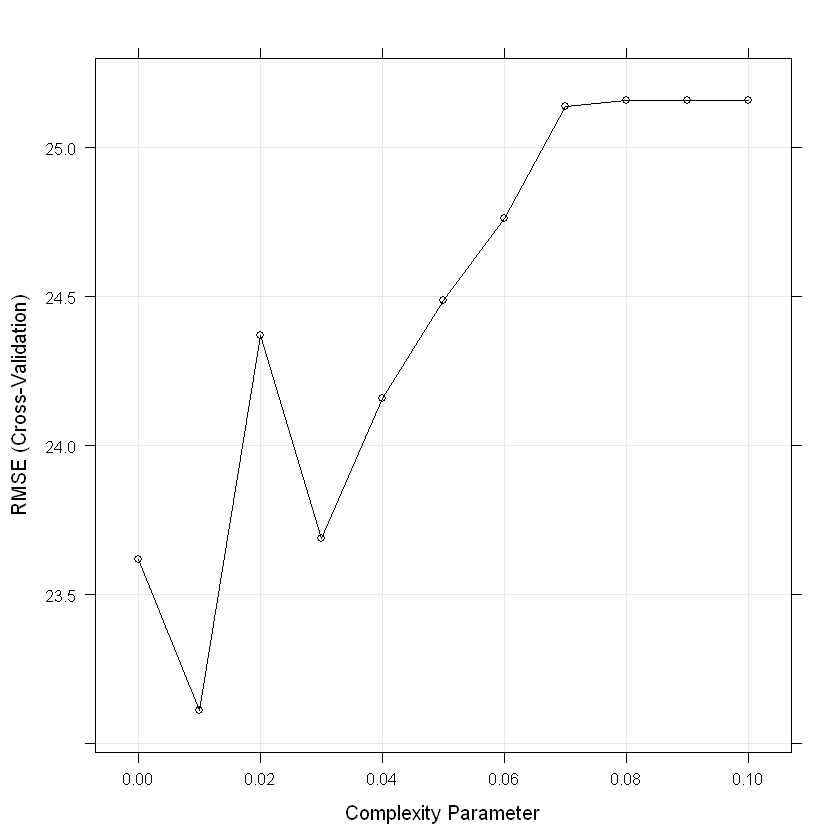

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7220, 7220, 7220, 7222, 7221, 7220, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  23.31317  0.3735412   7.681682
  0.01  23.65867  0.2803336   8.743808
  0.02  23.85219  0.2512546   9.398487
  0.03  23.58963  0.2518298   9.456006
  0.04  24.14028  0.2140322   9.619692
  0.05  24.49494  0.1850780  10.010563
  0.06  24.74804  0.1682312  10.085275
  0.07  25.26056  0.1304709  10.373590
  0.08  25.20588  0.1331238  10.425693
  0.09  25.20588  0.1331238  10.425693
  0.10  25.20588  0.1331238  10.425693

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


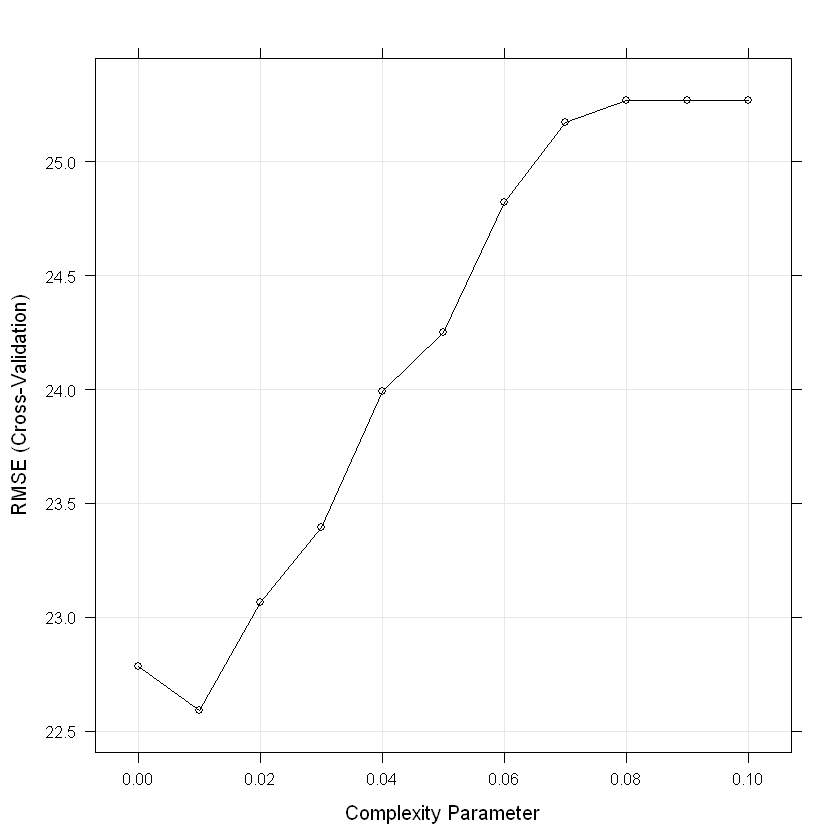

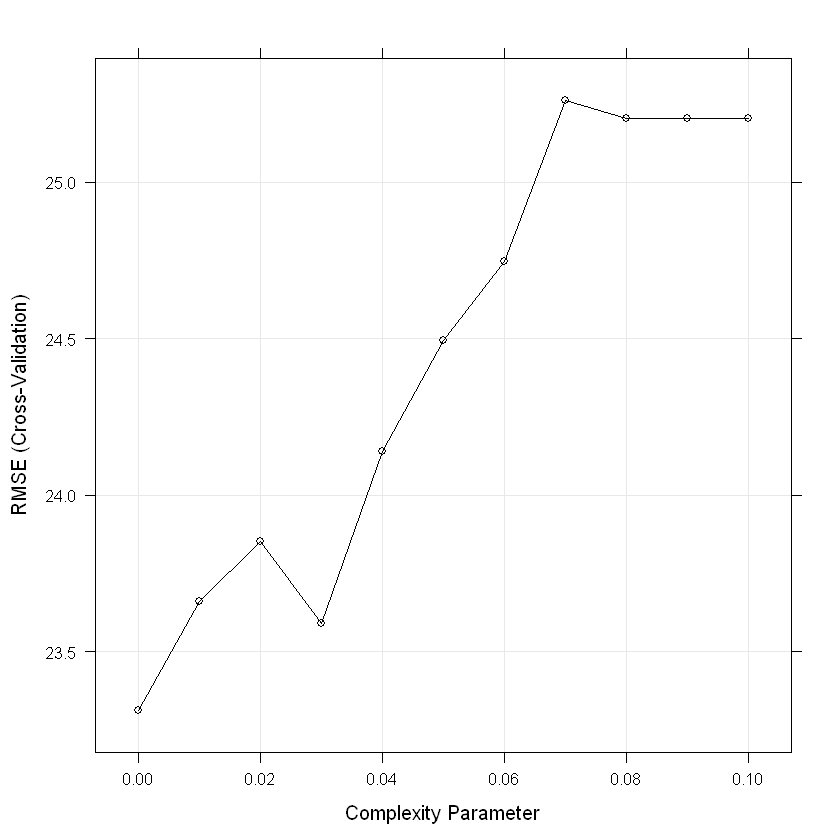

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7221, 7221, 7222, 7221, 7220, 7221, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  22.95767  0.3724630   7.705303
  0.01  23.24026  0.3028431   8.658028
  0.02  23.45036  0.2737250   9.260037
  0.03  23.59909  0.2544582   9.380761
  0.04  24.16481  0.2153038   9.649646
  0.05  24.31560  0.2001147   9.918720
  0.06  24.49023  0.1875050   9.975827
  0.07  25.28454  0.1326052  10.361658
  0.08  25.26901  0.1340236  10.394992
  0.09  25.26901  0.1340236  10.394992
  0.10  25.26901  0.1340236  10.394992

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


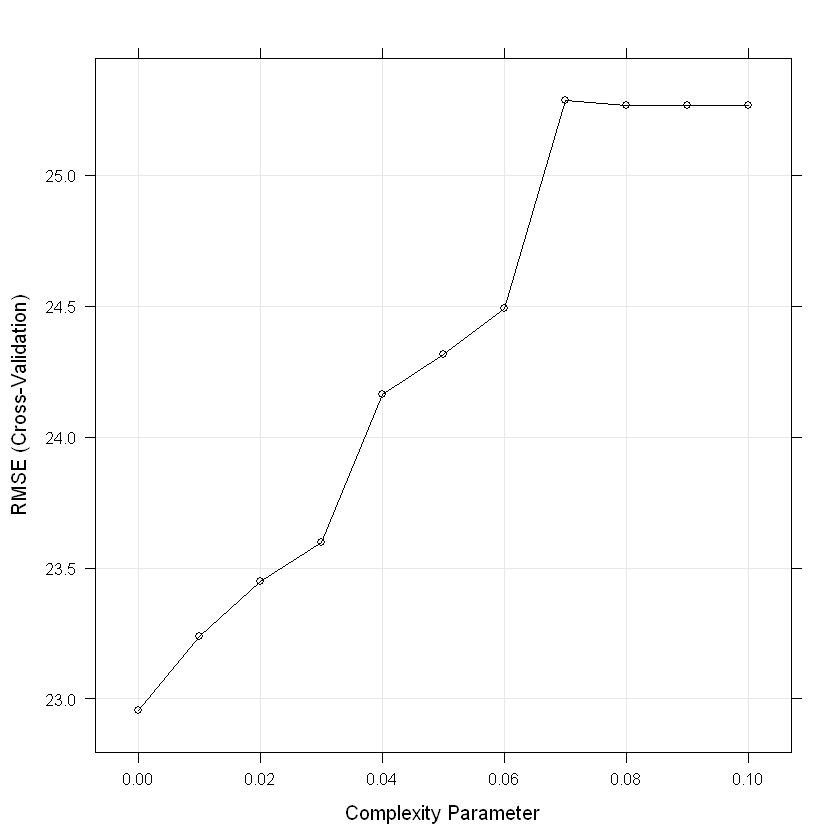

In [24]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.01)
#minbucket_grid=expand.grid(.cp=(5:10))
for(i in 5:10){
    tr=train(target~.,
          data=blog_train, 
          method="rpart",
          trControl=numFolds,
          tuneGrid= cpGrid,
            # minbucket=minbucket_grid
           control= rpart.control(minbucket = i)
            )
    trellis.par.set(caretTheme())
    print(plot(tr))    
    print(tr)
}

CART 

8023 samples
 280 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7220, 7221, 7221, 7220, 7220, 7221, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE      
  0.00  23.06776  0.3668206   7.581647
  0.01  23.62058  0.2773032   8.811138
  0.02  23.55890  0.2599936   9.367202
  0.03  23.89398  0.2345887   9.527665
  0.04  24.28802  0.2083409   9.623401
  0.05  24.51634  0.1882211   9.994792
  0.06  24.89896  0.1637056  10.138430
  0.07  25.36688  0.1272696  10.423904
  0.08  25.32701  0.1289648  10.439761
  0.09  25.32701  0.1289648  10.439761
  0.10  25.32701  0.1289648  10.439761

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


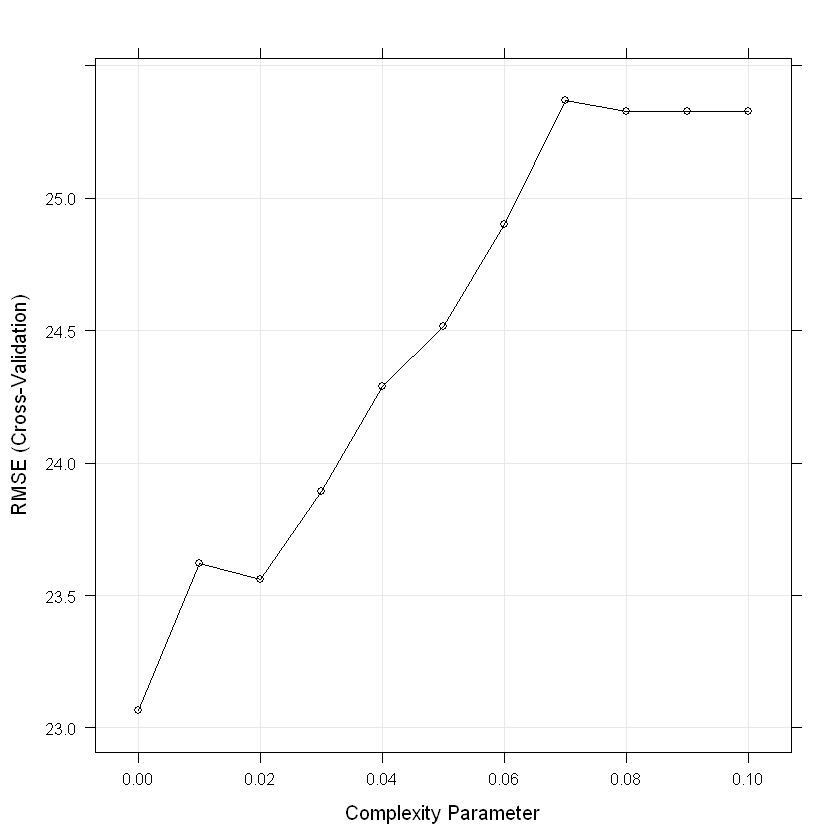

In [25]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.01)
tr=train(target~.,
      data=blog_train, 
      method="rpart",
      trControl=numFolds,
      tuneGrid= cpGrid,
        # minbucket=minbucket_grid
       control= rpart.control(minsplit = 8)
        )
trellis.par.set(caretTheme())
print(plot(tr))    
print(tr)

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

X2.0.4       X2.0.2      X10.0.1       X2.0.3       X2.0.1       X401.0 
1.550799e+06 1.403887e+06 1.127240e+06 8.807718e+05 8.767315e+05 4.406184e+05 
     X0.0.20    X15.52416    X32.44188        X15.0       X377.0   X14.044226 
4.363726e+05 4.253001e+05 4.083654e+05 3.908218e+05 3.661818e+05 2.396487e+05 
  X53.845657    X40.30467      X0.0.14         X3.0     X0.0.152      X.356.0 
2.133779e+05 1.489814e+05 1.476480e+05 1.187315e+05 1.062761e+05 9.772878e+04 
    X0.0.129      X0.0.27      X0.0.25     X0.0.165         X2.0      X0.0.80 
9.192272e+04 9.087635e+04 9.033122e+04 8.585505e+04 7.904684e+04 7.001978e+04 
     X0.0.37     X0.0.101     X0.0.204       X1.0.1   X48.475178     X0.0.224 
6.844944e+04 6.796432e+04 6.225738e+04 6.171861e+04 5.804078e+04 5.803387e+04 
     X0.0.86     X0.0.206     X0.0.142   X1.4799345      X0.0.30        X12.0 
5.772826e+04 5.436067e+04 5.327601e+04 5.228931e+04 5.129957e+04 5.060618e+04 
       X11.0     X0.0.184      X0.0.59    X1.795416   X1.0761671     X0.0.227 
5.060588e+04 4.928493e+04 4.656397e+04 4.566495e+04 4.557990e+04 4.411163e+04 
     X0.0.97     X0.0.191     X0.0.221     X0.0.232     X0.0.223     X0.0.109 
4.283016e+04 4.242507e+04 4.117038e+04 4.113104e+04 4.084925e+04 4.060461e+04 
    X0.0.190     X0.0.230     X0.0.225     X0.0.226     X0.0.111      X0.0.60 
3.583682e+04 3.573132e+04 3.520417e+04 3.295404e+04 3.292394e+04 3.271088e+04 
     X0.0.19     X0.0.228      X0.0.93     X0.0.139      X0.0.62     X0.0.222 
3.133450e+04 2.926939e+04 2.775267e+04 2.768668e+04 2.611934e+04 2.576617e+04 
    X0.0.215      X0.0.16     X0.0.231     X0.0.171     X0.0.117      X0.0.72 
2.519125e+04 2.440774e+04 2.430111e+04 2.426441e+04 2.240009e+04 2.187438e+04 
    X0.0.229      X0.0.98      X0.0.54      X0.0.78     X0.0.160      X0.0.77 
2.186766e+04 2.181955e+04 2.152707e+04 1.868576e+04 1.828481e+04 1.816604e+04 
     X0.0.35     X0.0.128      X0.0.94      X0.0.40     X0.0.186     X0.0.112 
1.804820e+04 1.773188e+04 1.767895e+04 1.729243e+04 1.711291e+04 1.591098e+04 
     X0.0.61     X0.0.138      X0.0.26      X0.0.99      X0.0.44     X0.0.210 
1.584535e+04 1.457788e+04 1.405460e+04 1.398649e+04 1.369785e+04 1.348740e+04 
     X0.0.79      X0.0.22     X0.0.151   X34.567566     X0.0.168      X0.0.63 
1.306951e+04 1.259033e+04 1.234982e+04 1.224512e+04 1.217895e+04 1.154961e+04 
     X0.0.33     X0.0.153     X0.0.116     X0.0.203    X0.972973     X0.0.213 
1.135319e+04 1.070669e+04 1.007610e+04 9.697752e+03 9.616374e+03 9.289333e+03 
    X0.0.199     X0.0.141      X0.0.74      X0.0.92     X0.0.133     X0.0.132 
9.181308e+03 9.055690e+03 9.030331e+03 8.870687e+03 8.847925e+03 8.572789e+03 
    X0.0.145      X0.0.15     X0.0.192       X0.0.4        X10.0     X0.0.174 
7.534488e+03 7.459155e+03 6.955035e+03 6.814320e+03 6.647351e+03 6.632451e+03 
        X9.0     X0.0.188      X0.0.68         X1.0      X0.0.73      X0.0.95 
6.467413e+03 6.248313e+03 6.022759e+03 5.928965e+03 5.877875e+03 5.669603e+03 
    X0.0.179      X0.0.46     X0.0.118      X0.0.18     X0.0.150      X0.0.28 
5.668790e+03 5.580115e+03 5.154798e+03 5.100932e+03 5.090043e+03 5.087327e+03 
    X0.0.205       X9.0.1       X9.0.2      X0.0.83      X0.0.85     X0.0.105 
4.974990e+03 4.681734e+03 4.678867e+03 4.602952e+03 4.466381e+03 4.190260e+03 
    X0.0.155     X0.0.115     X0.0.121     X0.0.180     X0.0.233     X0.0.108 
4.113777e+03 3.990598e+03 3.961893e+03 3.860923e+03 3.635307e+03 2.948209e+03 
    X0.0.144      X0.0.17      X0.0.58      X0.0.96      X0.0.66      X0.0.89 
2.942769e+03 2.878131e+03 2.748412e+03 2.722106e+03 2.691443e+03 2.539261e+03 
    X0.0.149     X0.0.159   X1.0780969      X0.0.47      X0.0.50     X0.0.134 
2.492988e+03 2.473937e+03 2.383447e+03 2.289498e+03 2.282020e+03 2.030403e+03 
       X.8.0   X0.4004914     X0.0.209      X0.0.57     X0.0.169     X0.0.120 
1.961301e+03 1.950686e+03 1.927753e+03 1.911815e+03 1.715783e+03 1.706531e+03 
    X0.0.198      X0.0.32    X1.704671     X0.0.146     

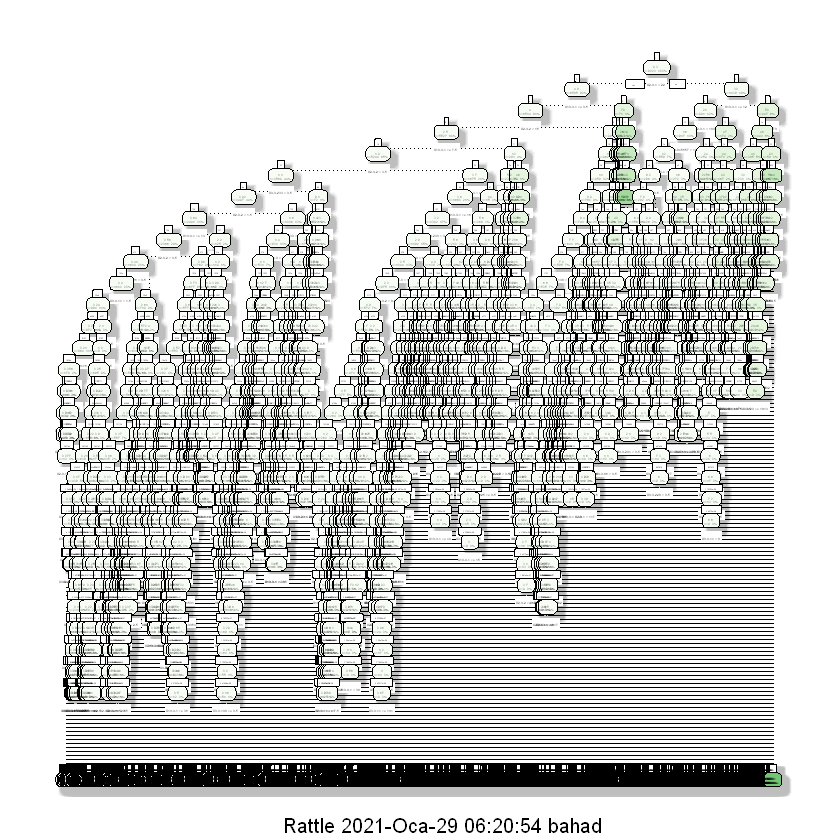

In [26]:
reg_tree_blog=tr$finalModel
fancyRpartPlot(reg_tree_blog)
reg_tree_blog$variable.importance

In [30]:
predicted_blog_dt=predict(reg_tree_blog,newdata=blog_test)

In [33]:
length(predicted_blog_dt)

[1] 1977

### Performanca Measure

In [35]:
perf_dt("Decision Tree with CV for Pisa Dataset",blog_test$target,as.numeric(predicted_blog_dt))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Pisa Dataset,1977,7.152757,16.66787,-0.1900829,Inf,0.338767,6.968534,0.9742445


## Random Forest(RF)

In [32]:
Sys.time()
random_forest_blog=randomForest(target~.,data=blog_train,
                           ntree=100,nodesize=100)
random_forest_blog
Sys.time()

[1] "2021-01-28 04:53:31 +03"


Call:
 randomForest(formula = target ~ ., data = blog_train, ntree = 100,      nodesize = 100) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 93

          Mean of squared residuals: 438.4841
                    % Var explained: 41.3

[1] "2021-01-28 04:54:00 +03"

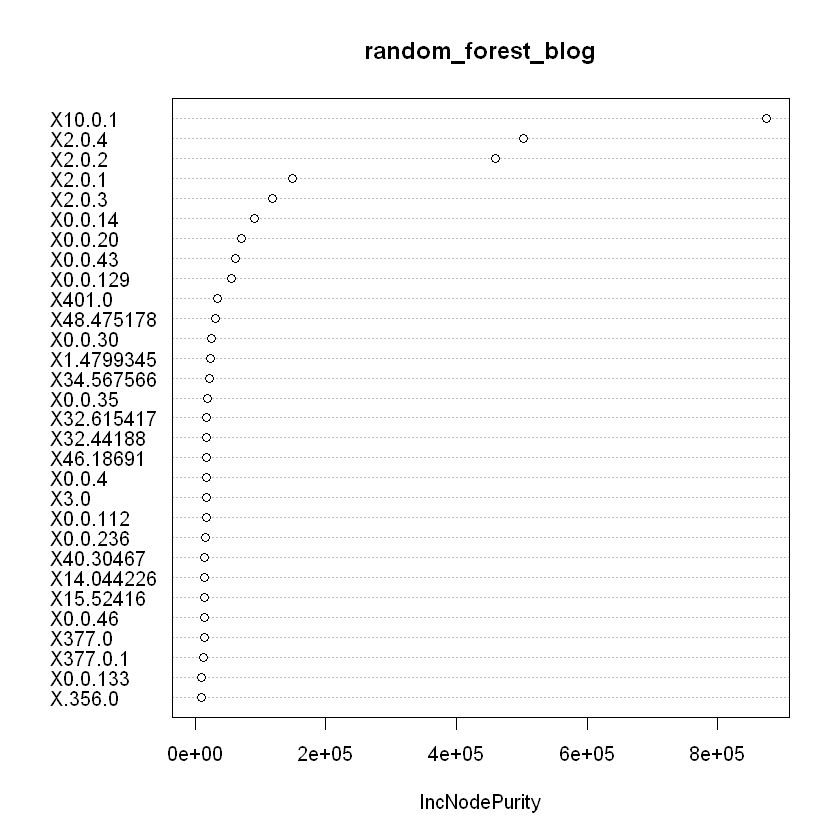

In [33]:
varImpPlot(random_forest_blog)

In [34]:
RandomForest_blog=predict(random_forest_blog,newdata=blog_test)

### Performanca Measure

In [35]:
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_blog), as.numeric(blog_test$target))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,1977,8.860859,14.66844,0.1927693,0.9843391,0.2715854,5.814379,0.6561868


## Stochastic Gradient Boosting(SGB)

In [36]:
noftrees=100
depth=5
learning_rate=0.01
sampling_fraction=1
boosting_model_blog=gbm(target~., data=blog_train ,distribution = "gaussian", n.trees = noftrees,
        interaction.depth = depth, n.minobsinnode = 5, shrinkage =learning_rate ,
        bag.fraction = sampling_fraction)

predicted_blog_sgb=predict(boosting_model_blog,newdata=blog_test,n.trees=noftrees)   

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 8: X0.0.1 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 13: X0.0.2 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 28: X0.0.5 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 33: X0.0.7 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 35: X0.0.8 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 38: X0.0.9 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 40: X0.0.10 has no variation."Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 43: X

### Performanca Measure

In [37]:
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(predicted_blog_sgb), as.numeric(blog_test$target))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,1977,8.994042,8.125807,0.2047227,0.8722316,0.2979597,7.522866,0.8364278


# General Comparision